## Basic setup

In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.neighbors import NearestCentroid
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

seed = 1234
np.random.seed(seed)  

In [2]:
# loading and combining batches of samples
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return np.array(dict[b'data']), np.array(dict[b'labels'])

def load_class_labels(file="cifar-10-batches-py/batches.meta"):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return [name.decode('utf-8') for name in dict[b'label_names']]

X_partial, y_partial = [], []
for i in range(1, 6):
    X_batch, y_batch = unpickle(f"cifar-10-batches-py/data_batch_{i}")
    X_partial.append(X_batch)
    y_partial.append(y_batch)

X_train_full_original = np.vstack(X_partial)
y_train_full = np.hstack(y_partial)

X_train_original, X_val_original, y_train, y_val = train_test_split(X_train_full_original, y_train_full, random_state=seed, test_size=0.2, shuffle=True)  # use train_test_split to split out the validation set from the training set
X_test_original, y_test = unpickle("cifar-10-batches-py/test_batch")  # keeping the original test data for display purposes

scaler = StandardScaler().fit(X_train_original)  # scale the data
X_train = scaler.transform(X_train_original)
X_val = scaler.transform(X_val_original)
X_train_full = scaler.transform(X_train_full_original)
X_test = scaler.transform(X_test_original)

class_labels = load_class_labels()

In [3]:
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)
print(class_labels)

(40000, 3072) (40000,)
(10000, 3072) (10000,)
(10000, 3072) (10000,)
['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Dataset exploration

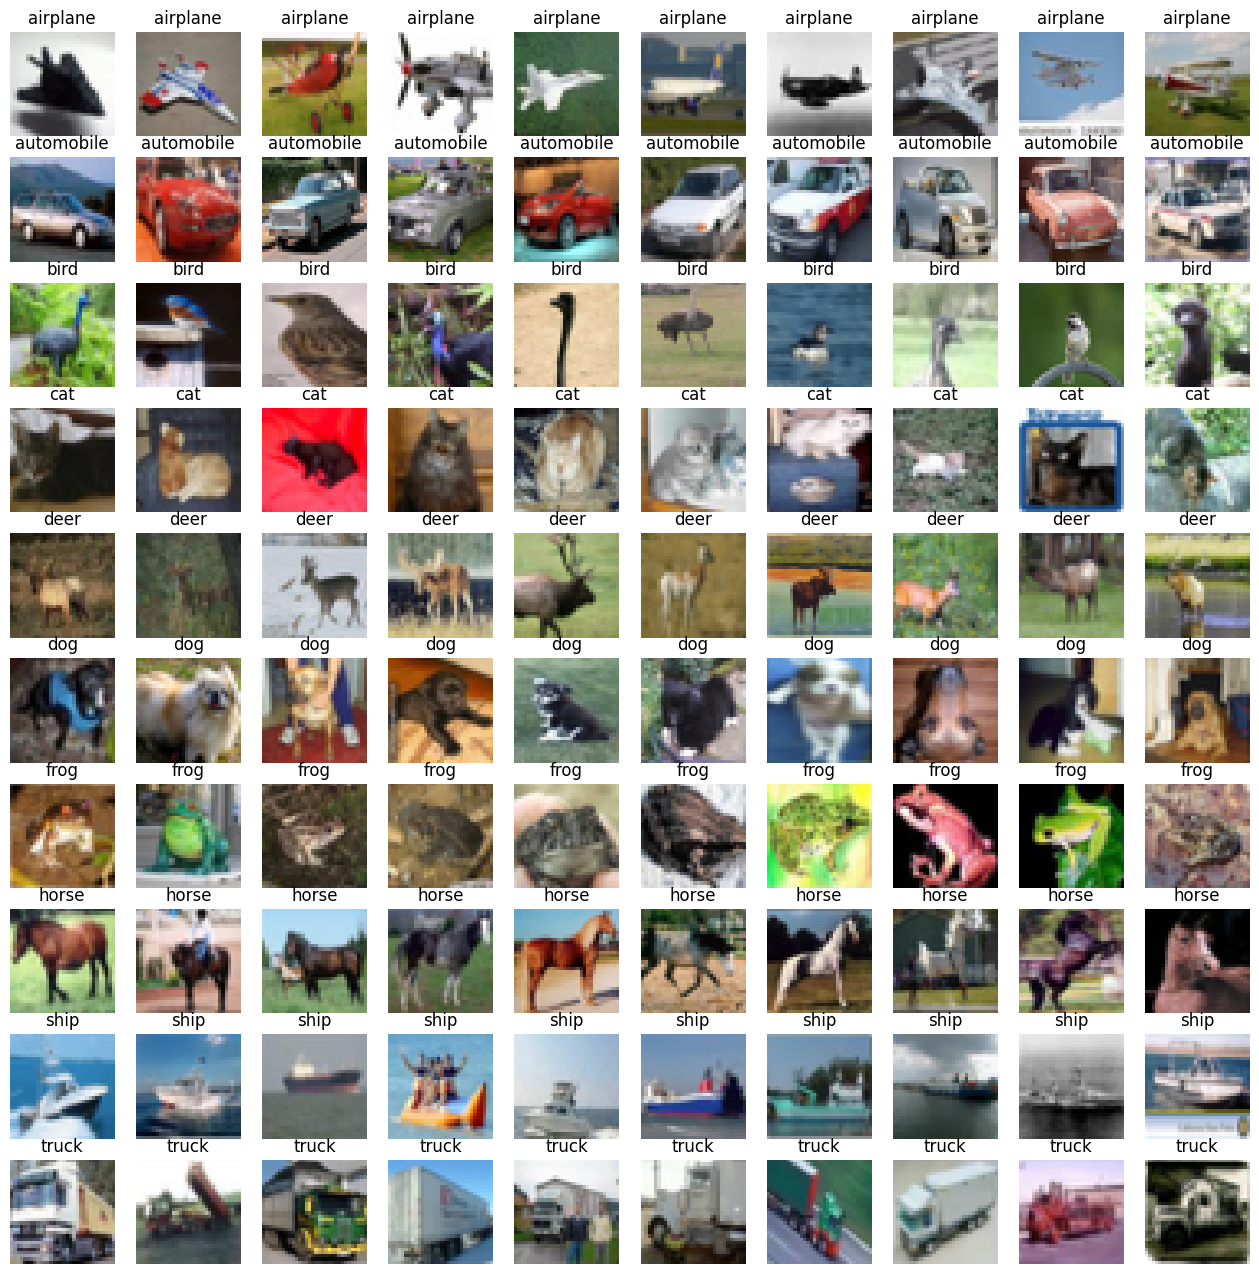

In [4]:
fig, axes = plt.subplots(10, 10, figsize=(16,16))
for cls in range(10):
    idxs = np.where(y_train_full == cls)[0]
    samples = idxs[:10]
    for j, sample in enumerate(samples):
        img = X_train_full_original[sample].reshape(3,32,32).transpose(1,2,0)
        axes[cls,j].imshow(img.astype('uint8'))
        axes[cls,j].axis('off')
        axes[cls,j].set_title(class_labels[cls])

## Some helper funtions

In [5]:
def visualize_sample_prediction(clf):  # display some sample images and their predictions given a classifier
    figure, axes = plt.subplots(4, 8, figsize=(12, 6))
    for i, ax in enumerate(axes.ravel()):
        image = X_test_original[i].reshape(3,32,32).transpose(1,2,0)

        predicted = clf.predict([X_test[i]])[0]

        ax.imshow(image)
        ax.set_title(f"True: {class_labels[y_test[i]]}\nPred: {class_labels[predicted]}")

    figure.suptitle(f"CIFAR-10: {clf.__class__.__name__} Predictions", fontsize=16)
    plt.tight_layout()
    plt.show()

In [6]:
def plot_learning_curve(clf):  # sklearn's learning_curve funtion uses n fold cross validation instead scoring against dedicated validation set
    train_sizes, train_scores, val_scores = learning_curve(clf, X_train_full, y_train_full, train_sizes=np.linspace(0.1, 1.0, 10), shuffle=True, random_state=seed, cv=5, scoring='accuracy', n_jobs=12)
    train_means = np.mean(train_scores, axis=1)
    val_means = np.mean(val_scores, axis=1)

    train_error = 1 - train_means
    val_error = 1 - val_means

    plt.figure(figsize=(8,5))
    plt.plot(train_sizes, train_error, label="Training Error")
    plt.plot(train_sizes, val_error, label="Validation Error")
    plt.xlabel("Training size")
    plt.ylabel("Error rate")
    plt.title(f"Learning Curve: {clf.__class__.__name__}")
    plt.legend()
    plt.tight_layout()
    plt.show()


## Find the best parameters for KNN (n_neighbors and weights)

1 uniform 0.65994
1 distance 0.65994
3 uniform 0.67376
3 distance 0.65366
5 uniform 0.6674800000000001
5 distance 0.6510400000000001
7 uniform 0.66882
7 distance 0.65248
9 uniform 0.66762
9 distance 0.65388
11 uniform 0.671
11 distance 0.65838
13 uniform 0.67098
13 distance 0.66098
15 uniform 0.67186
15 distance 0.6632800000000001
17 uniform 0.67232
17 distance 0.66518
19 uniform 0.67492
19 distance 0.6678
21 uniform 0.67636
21 distance 0.66986


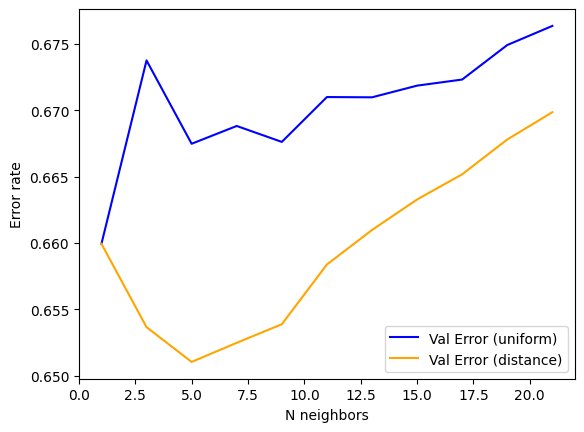

Best parameter: {'n_neighbors': 5, 'weights': 'distance'}


In [7]:
def knn_find_best_hyperparameter():
    neighbors = [i for i in range(1, 22, 2)]
    weights = ["uniform", "distance"]

    uniform_val_error = []

    distance_val_error = []

    best_val_error = np.inf
    best_parameter = {
        "n_neighbors": 1,
        "weights": "uniform"
    }
    for n in neighbors:
        for weight in weights:
            knn_clf = KNeighborsClassifier(n_neighbors=n, weights=weight)
            # using the full training set (before split) for 5 fold cross validation and take the average of scores
            cross_val_error = 1 - np.mean(cross_val_score(knn_clf, X_train_full, y_train_full, cv=5)) 
            print(n, weight, cross_val_error)

            if cross_val_error < best_val_error:  # save the best parameters
                best_val_error = cross_val_error
                best_parameter["n_neighbors"] = n
                best_parameter["weights"] = weight

            if weight == "uniform":  # save errors for later plot
                uniform_val_error.append(cross_val_error)
            else:
                distance_val_error.append(cross_val_error)

    plt.plot(neighbors, uniform_val_error, label="Val Error (uniform)", color = "blue")
    plt.plot(neighbors, distance_val_error, label="Val Error (distance)", color = "orange")
    plt.xlabel("N neighbors")
    plt.ylabel("Error rate")
    plt.legend()
    plt.show()

    return best_parameter

knn_best_parameter = knn_find_best_hyperparameter()
print(f"Best parameter: {knn_best_parameter}")

## KNN learning curve

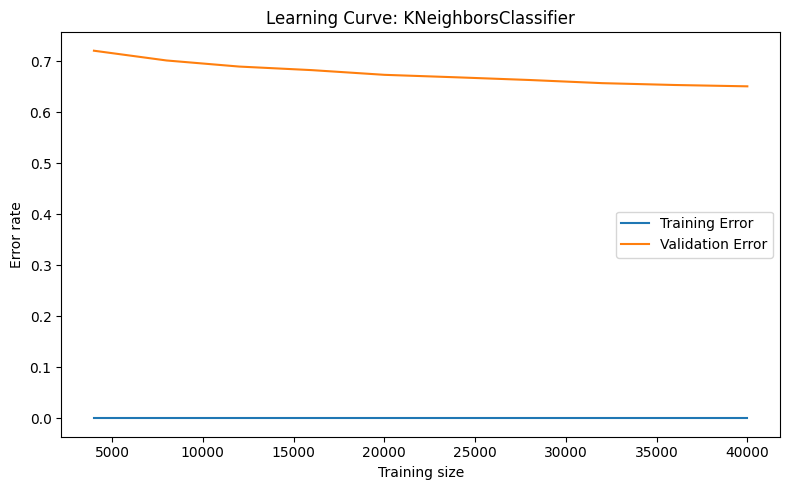

In [8]:
knn_best = KNeighborsClassifier(**knn_best_parameter)
# knn_best.fit(X_train, y_train)
plot_learning_curve(knn_best)

## Measuring KNN performance on test set

knn training error: 0.0
knn test error: 0.65
knn prediction time per sample (trained on 40,000 data): 0.7475396394729614 ms


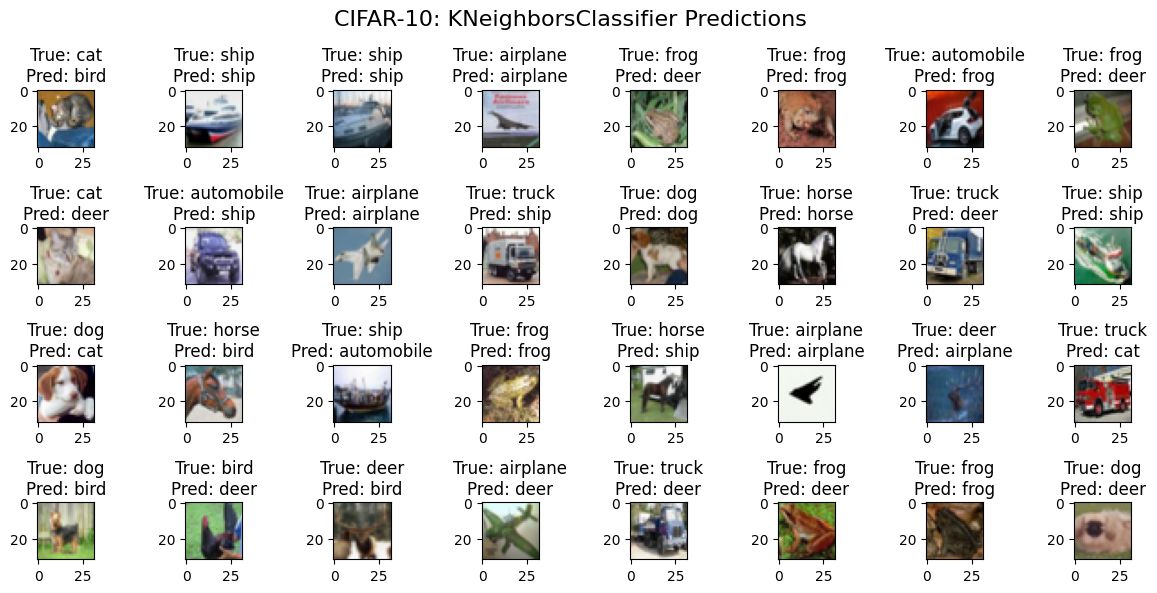

In [9]:
knn_best = KNeighborsClassifier(**knn_best_parameter)
knn_best.fit(X_train, y_train)
knn_train_error = 1 - knn_best.score(X_train, y_train)

start_time = time.time()
knn_test_error = 1 - knn_best.score(X_test, y_test)
end_time = time.time()
elapsed_time = end_time - start_time
time_per_sample = elapsed_time / len(X_test)

print(f"knn training error: {knn_train_error}")
print(f"knn test error: {knn_test_error}")
print(f"knn prediction time per sample (trained on 40,000 data): {time_per_sample * 1000} ms")
visualize_sample_prediction(knn_best)

## Find the best parameters for logistic 

0.01 l1 0.584425 0.6081
0.01 l2 0.5171 0.6083000000000001
0.1 l1 0.532525 0.6002000000000001
0.1 l2 0.5085500000000001 0.6172
1 l1 0.509925 0.6142000000000001
1 l2 0.50825 0.618
10 l1 0.50825 0.6179
10 l2 0.5081249999999999 0.6182000000000001
50 l1 0.50825 0.618
50 l2 0.5081249999999999 0.6183000000000001
100 l1 0.508175 0.6181
100 l2 0.5081249999999999 0.6183000000000001


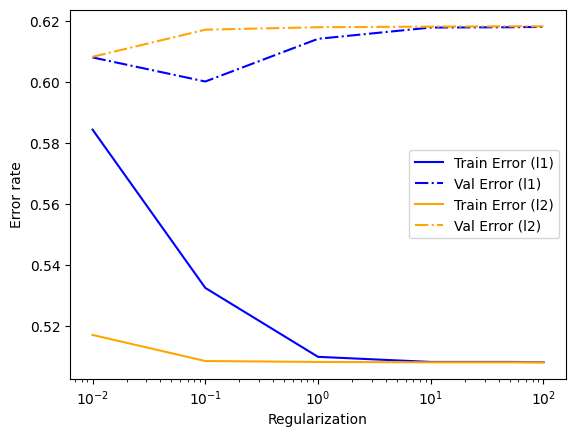

Best parameter: {'C': 0.1, 'penalty': 'l1', 'solver': 'saga', 'random_state': 1234, 'n_jobs': -1, 'multi_class': 'ovr'}


In [10]:
def logistic_find_best_hyperparameter():
    regularizations = [0.01, 0.1, 1, 10, 50, 100]
    penalties = ["l1", "l2"]

    l1_train_error = []
    l1_val_error = []

    l2_train_error = []
    l2_val_error = []

    best_val_error = np.inf
    best_parameter = {
        "C": 0,
        "penalty": "l1",
        "solver": "saga",
        "random_state": seed,
        "n_jobs": -1,  # enables utilization of all cores to speed up
        "multi_class": "ovr"
    }
    for c in regularizations:
        for p in penalties:
            logistic_clf = LogisticRegression(random_state=seed, penalty=p, C=c, solver='saga', n_jobs=-1, multi_class="ovr")
            logistic_clf.fit(X_train, y_train)

            train_error = 1 - logistic_clf.score(X_train, y_train)
            val_error = 1 - logistic_clf.score(X_val, y_val)
            print(c, p, train_error, val_error)

            if val_error < best_val_error:
                best_val_error = val_error
                best_parameter["C"] = c
                best_parameter["penalty"] = p

            if p == "l1":  # save errors for later plot
                l1_train_error.append(train_error)
                l1_val_error.append(val_error)
            else:
                l2_train_error.append(train_error)
                l2_val_error.append(val_error)

    plt.semilogx(regularizations, l1_train_error, label="Train Error (l1)", color = "blue")
    plt.semilogx(regularizations, l1_val_error, label="Val Error (l1)",  linestyle='-.', color = "blue")
    plt.semilogx(regularizations, l2_train_error, label="Train Error (l2)", color = "orange")
    plt.semilogx(regularizations, l2_val_error, label="Val Error (l2)", linestyle='-.', color = "orange")
    plt.xlabel("Regularization")
    plt.ylabel("Error rate")
    plt.legend()
    plt.show()

    return best_parameter

logistic_best_parameter = logistic_find_best_hyperparameter()
print(f"Best parameter: {logistic_best_parameter}")

## Logistic learning curve

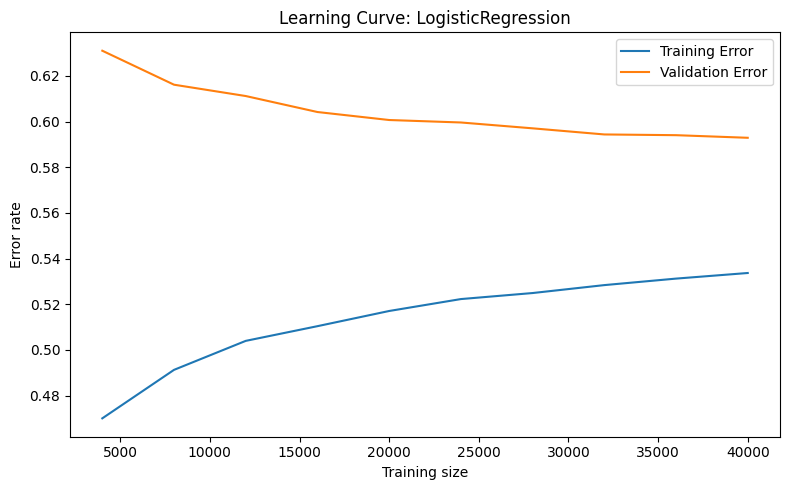

In [11]:
logistic_best = LogisticRegression(**logistic_best_parameter)
# logistic_best.fit(X_train, y_train)
plot_learning_curve(logistic_best)

## Measuring logistic performance on test set

logistic training error: 0.532525
logistic test error: 0.5929
logistic prediction time per sample: 0.008307528495788573 ms


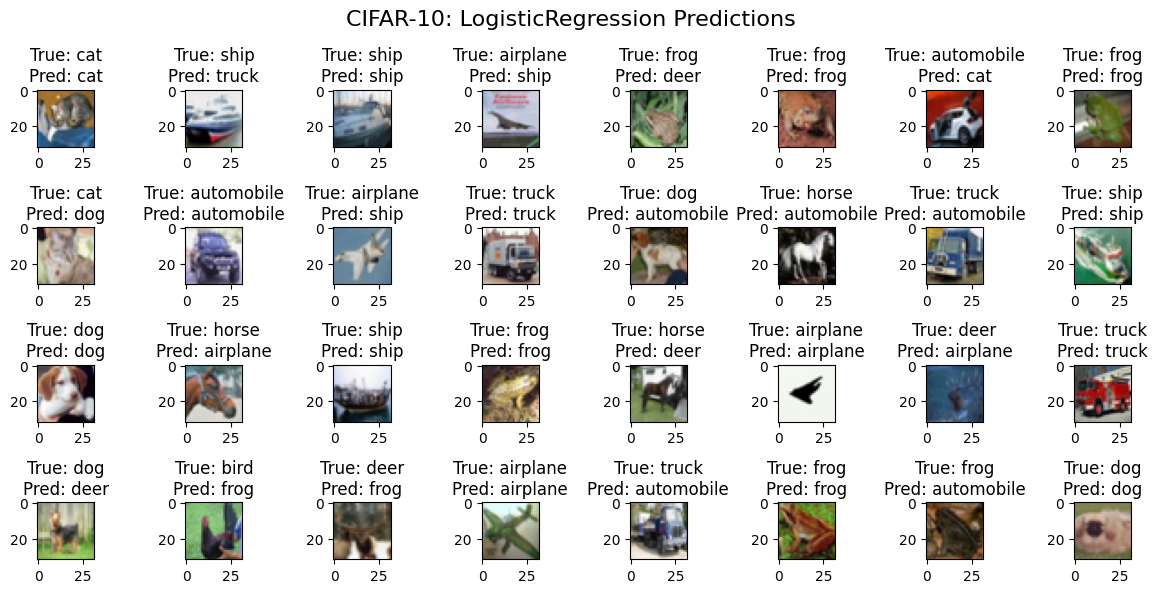

In [12]:
logistic_best.fit(X_train, y_train)
logistic_train_error = 1 - logistic_best.score(X_train, y_train)

start_time = time.time()
logistic_test_error = 1 - logistic_best.score(X_test, y_test)
end_time = time.time()
elapsed_time = end_time - start_time
time_per_sample = elapsed_time / len(X_test)

print(f"logistic training error: {logistic_train_error}")
print(f"logistic test error: {logistic_test_error}")
print(f"logistic prediction time per sample: {time_per_sample * 1000} ms")
visualize_sample_prediction(logistic_best)

## Find the best parameters for MLP

In [13]:
def mlp_find_best_hyperparameter():
    param_grid = {
        "hidden_layer_sizes": [(100,100), (150,50)],
        "activation": ["relu"],
        "solver": ["adam"],
        "alpha": [0.0001, 0.01, 0.05, 0.1, 0.5],
        "learning_rate_init": [0.001, 0.005, 0.01]
    }

    best_val_error = np.inf
    best_parameter = None
    results = []

    for params in ParameterGrid(param_grid):
        mlp_clf = MLPClassifier(random_state=seed, early_stopping=True, **params)
        mlp_clf.fit(X_train, y_train)

        val_error = 1 - mlp_clf.score(X_val, y_val)
        results.append({**params, "val_error": val_error})
        print(params, val_error)

        if val_error < best_val_error:
            best_val_error, best_parameter = val_error, params

    df = pd.DataFrame(results)
    df = df.sort_values("val_error", ascending=True).reset_index(drop=True)
    display(df.head(10))

    return best_parameter

mlp_best_parameter = mlp_find_best_hyperparameter()
print(f"Best parameter: {mlp_best_parameter}")

{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 100), 'learning_rate_init': 0.001, 'solver': 'adam'} 0.5156000000000001
{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 100), 'learning_rate_init': 0.005, 'solver': 'adam'} 0.5261
{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 100), 'learning_rate_init': 0.01, 'solver': 'adam'} 0.5394
{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (150, 50), 'learning_rate_init': 0.001, 'solver': 'adam'} 0.5156000000000001
{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (150, 50), 'learning_rate_init': 0.005, 'solver': 'adam'} 0.5085
{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (150, 50), 'learning_rate_init': 0.01, 'solver': 'adam'} 0.7021999999999999
{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (100, 100), 'learning_rate_init': 0.001, 'solver': 'adam'} 0.5127999999999999
{'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (10

,activation,alpha,hidden_layer_sizes,learning_rate_init,solver,val_error
0,relu,0.5000,"(150, 50)",0.001,adam,0.4898
1,relu,0.5000,"(100, 100)",0.001,adam,0.4926
2,relu,0.1000,"(150, 50)",0.001,adam,0.5073
3,relu,0.0001,"(150, 50)",0.005,adam,0.5085
4,relu,0.0500,"(150, 50)",0.001,adam,0.5097
5,relu,0.0500,"(100, 100)",0.001,adam,0.5114
6,relu,0.0100,"(100, 100)",0.001,adam,0.5128
7,relu,0.0100,"(150, 50)",0.001,adam,0.5146
8,relu,0.0001,"(150, 50)",0.001,adam,0.5156
9,relu,0.0001,"(100, 100)",0.001,adam,0.5156


Best parameter: {'activation': 'relu', 'alpha': 0.5, 'hidden_layer_sizes': (150, 50), 'learning_rate_init': 0.001, 'solver': 'adam'}


## MLP leraning curve

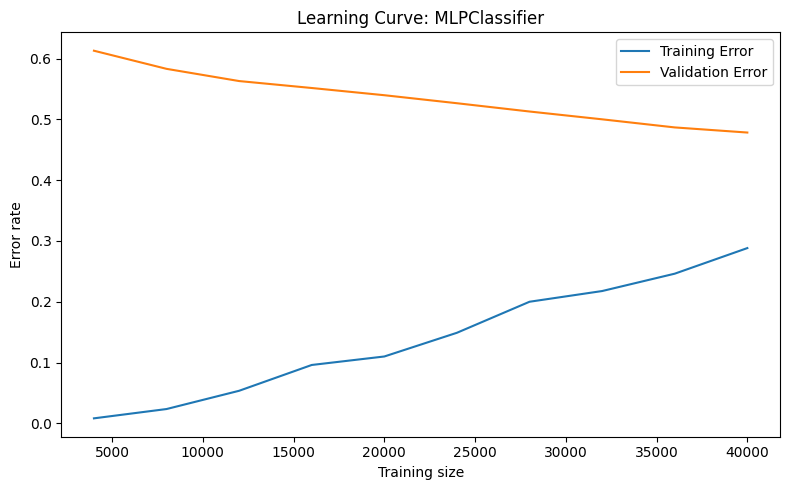

In [ ]:
mlp_best = MLPClassifier(random_state=seed, early_stopping=False, **mlp_best_parameter)
# mlp_best.fit(X_train, y_train)
plot_learning_curve(mlp_best)

## Measuring MLP performance on test set

MLP training error: 0.29474999999999996
MLP test error: 0.49229999999999996
MLP prediction time per sample: 0.00870985984802246 ms


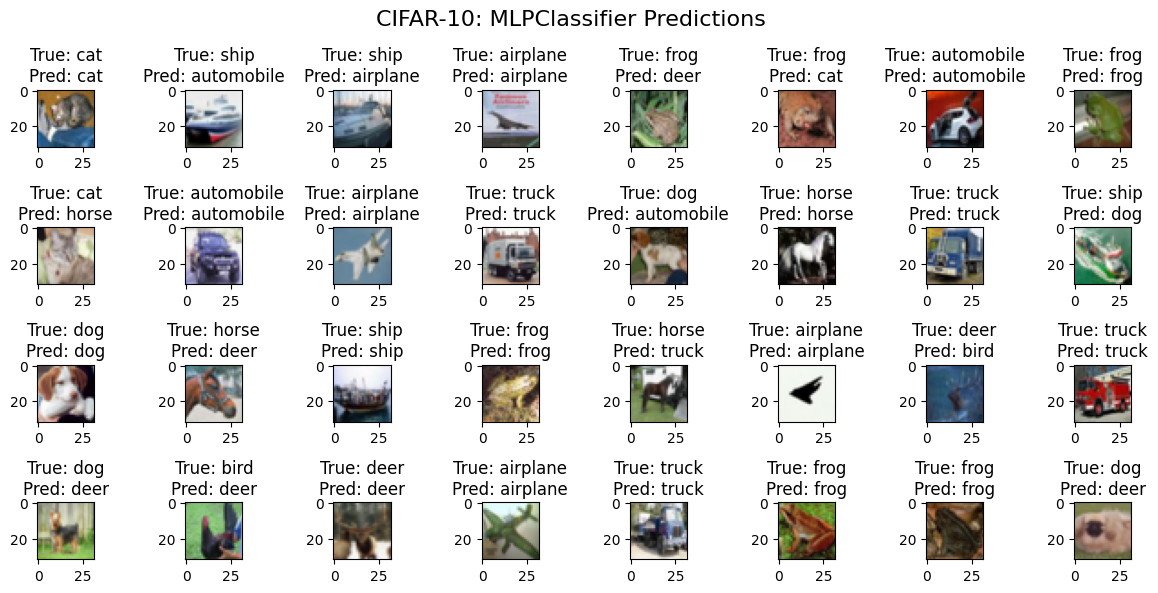

In [15]:
mlp_best = MLPClassifier(random_state=seed, **mlp_best_parameter)
mlp_best.fit(X_train, y_train)
mlp_train_error = 1 - mlp_best.score(X_train, y_train)

start_time = time.time()
mlp_test_error = 1 - mlp_best.score(X_test, y_test)
end_time = time.time()
elapsed_time = end_time - start_time
time_per_sample = elapsed_time / len(X_test)

print(f"MLP training error: {mlp_train_error}")
print(f"MLP test error: {mlp_test_error}")
print(f"MLP prediction time per sample: {time_per_sample * 1000} ms")
visualize_sample_prediction(mlp_best)

## Find the best parameters for Random forest

In [16]:
def random_forest_find_best_hyperparameter():
    param_grid = {
        "n_estimators":       [100, 200, 500],
        "max_depth":          [None, 10, 20, 50],
        "min_samples_leaf":   [1, 2, 5],
        "max_features":       ["sqrt", "log2"],
        "bootstrap":          [True]
    }

    best_val_error = np.inf
    best_parameter = None
    results = []

    for params in ParameterGrid(param_grid):
        rf_clf = RandomForestClassifier(random_state=seed, n_jobs=12, **params)
        rf_clf.fit(X_train, y_train)

        val_error = 1 - rf_clf.score(X_val, y_val)
        results.append({**params, "val_error": val_error})
        print(params, val_error)

        if val_error < best_val_error:
            best_val_error, best_parameter = val_error, params

    df = pd.DataFrame(results)
    df = df.sort_values("val_error", ascending=True).reset_index(drop=True)
    display(df.head(10))

    return best_parameter

rf_best_parameter = random_forest_find_best_hyperparameter()
print(f"Best parameter: {rf_best_parameter}")

{'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 100} 0.5469999999999999
{'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 200} 0.5313
{'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 500} 0.5227999999999999
{'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 100} 0.546
{'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 200} 0.5369999999999999
{'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'n_estimators': 500} 0.5273
{'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 100} 0.5455
{'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 200} 0.5385
{'bootstrap': True, 'max_depth': None, 'max_features'

,bootstrap,max_depth,max_features,min_samples_leaf,n_estimators,val_error
0,True,NaN,sqrt,1,500,0.5228
1,True,50.0,sqrt,1,500,0.5233
2,True,20.0,sqrt,1,500,0.5264
3,True,NaN,sqrt,2,500,0.5273
4,True,50.0,sqrt,2,500,0.5275
5,True,20.0,sqrt,2,500,0.5308
6,True,NaN,sqrt,1,200,0.5313
7,True,50.0,sqrt,1,200,0.5316
8,True,50.0,log2,1,500,0.5316
9,True,NaN,log2,1,500,0.5324


Best parameter: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 500}


## Random Forest learning curve

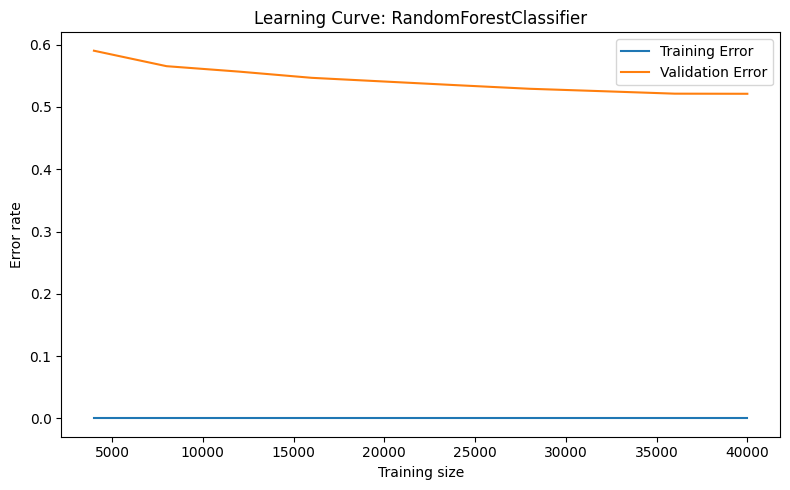

In [17]:
rf_best = RandomForestClassifier(random_state=seed, **rf_best_parameter)
plot_learning_curve(rf_best)

## Random Forest performance

RF training error: 0.0
RF test error: 0.5206
RF prediction time per sample: 0.19778151512145994 ms


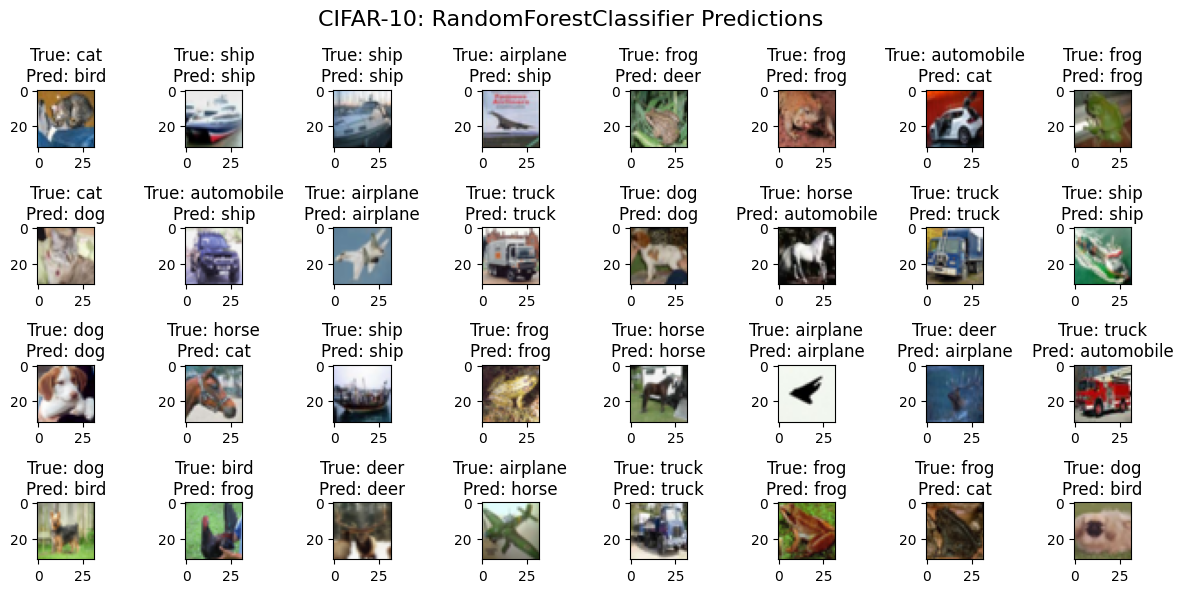

In [18]:
rf_best = RandomForestClassifier(random_state=seed, **rf_best_parameter)
rf_best.fit(X_train, y_train)
rf_train_error = 1 - rf_best.score(X_train, y_train)

start_time = time.time()
rf_test_error = 1 - rf_best.score(X_test, y_test)
end_time = time.time()
elapsed_time = end_time - start_time
time_per_sample = elapsed_time / len(X_test)

print(f"RF training error: {rf_train_error}")
print(f"RF test error: {rf_test_error}")
print(f"RF prediction time per sample: {time_per_sample * 1000} ms")
visualize_sample_prediction(rf_best)